# Neumonia Tokyo Example with echelon.contrib.geo

This is the example of performing the same analysis as [this example](./application-neumonia-Tokyo) using the `echelon.contrib.geo` module.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

## Version Information

In [2]:
import echelon

import matplotlib
# For some reason, NetworkX plot functionality (nx.draw()) seems to fail with a newer matplotlib:
# https://stackoverflow.com/questions/63198347/attributeerror-module-matplotlib-cbook-has-no-attribute-iterable
# assert matplotlib.__version__ =='2.2.3'

import echelon.contrib.geo as echelon_geo

for module in [echelon, matplotlib] + echelon_geo.required_modules:
    print(module.__name__, module.__version__)

echelon 1.0.3
matplotlib 3.4.3
geopandas 0.10.2
libpysal 4.5.1


## Downloading Data

In [3]:
import urllib.request
from pathlib import Path
import zipfile
import shutil

data_dir = Path('data/application-neumonia-Tokyo')
data_dir.mkdir(exist_ok=True, parents=True)

_filename = data_dir / 'onepoint.zip'
if not _filename.exists():
    urllib.request.urlretrieve('https://fishi.ems.okayama-u.ac.jp/fishioka/onepoint.zip', _filename)

if not (data_dir / 'onepoint').exists():
    with zipfile.ZipFile(_filename) as _f:
        _f.extractall(data_dir)

    for _p in (data_dir / 'onepoint').glob("*"):
        shutil.move(str(_p), str(data_dir))

print([a.name for a in (data_dir / 'data').iterdir()])
print([a.name for a in (data_dir / 'shapefile').iterdir()])

['table42.csv', 'table43.csv']
['jpn_adm.prj', 'jpn_adm.sbn', 'jpn_adm.shp', 'jpn_adm.shx', 'jpn_adm.sbx', 'jpn_adm.shp.xml', 'jpn_adm.dbf']


## Loading data

### GIS data

In [4]:
import numpy as np
import geopandas as gpd

gdf = gpd.read_file(data_dir / 'shapefile' / 'jpn_adm.shp')
Tokyo_gdf = gdf[gdf['adm_code'].isin([str(s) for s in range(13101, 13123+1)])]
Tokyo_gdf = Tokyo_gdf.reset_index(drop=True)

display(Tokyo_gdf.head(3))

,adm_code,KEN,SIKUCHOSON,geometry
0,13101,東京都,千代田区,"POLYGON ((139.77010 35.70527, 139.77310 35.705..."
1,13102,東京都,中央区,"POLYGON ((139.78889 35.69466, 139.79041 35.689..."
2,13103,東京都,港区,"MULTIPOLYGON (((139.75751 35.62413, 139.75349 ..."


### Case count data

In [5]:
import pandas as pd

table42 = pd.read_csv(data_dir / 'data/table42.csv')
table43 = pd.read_csv(data_dir / 'data/table43.csv', encoding="shift-jis")

from IPython.display import display

display(table42)
display(table43.head(3))

,age,n,o
0,1,539781,2
1,2,3174956,89
2,3,867227,2837


,ID,Name,n,n1,n2,n3,o
0,1,千代田区,29987,3836,21637,4514,11
1,2,中央区,71448,9705,51976,9767,29
2,3,港区,117353,16505,83354,17494,31


## Preparing Data

In [6]:
## Derived columns
p = table42['o'] / table42['n']
e = table43['n1']*p[0] + table43['n2']*p[1] + table43['n3']*p[2]
SMR = table43['o'] / e
table43['SMR'] = SMR

table43

,ID,Name,n,n1,n2,n3,o,SMR
0,1,千代田区,29987,3836,21637,4514,11,0.714861
1,2,中央区,71448,9705,51976,9767,29,0.867116
2,3,港区,117353,16505,83354,17494,31,0.519902
3,4,新宿区,170255,14992,126589,28674,74,0.759702
4,5,文京区,101755,12938,71297,17520,41,0.690695
5,6,台東区,99346,9150,69041,21155,76,1.067797
6,7,墨田区,131814,14372,90833,26609,75,0.836617
7,8,江東区,250950,33457,169528,47965,131,0.809710
8,9,品川区,187822,22083,131278,34461,110,0.944241
9,10,目黒区,129443,14973,91961,22509,71,0.930927


In [7]:
Tokyo_gdf = Tokyo_gdf.merge(table43[['Name', 'ID']], left_on='SIKUCHOSON', right_on='Name')

In [8]:
from echelon.contrib.geo import GISEchelonAnalysis
api = GISEchelonAnalysis()

result = api(table43, Tokyo_gdf, 'ID', 'Name', 'SMR')

print(api.dendrogram(result))

E10(江東区): [港区, 江東区]
 (max: 0.8097101496026745)
├── E9(荒川区): [文京区, 千代田区, 新宿区, 墨田区, 中央区, 目黒区, 杉並区, 世田谷区, 荒川区]
│    (max: 0.9542372963272185)
│   ├── E8(中野区): [中野区]
│   │    (max: 0.9922921961759763)
│   │   ├── E7(北区): [北区]
│   │   │    (max: 1.0375137862297261)
│   │   │   ├── E2(練馬区): [豊島区, 板橋区, 練馬区]
│   │   │   │    (max: 1.1694088184210711)
│   │   │   └── E1(葛飾区): [足立区, 葛飾区]
│   │   │        (max: 1.2984145393208892)
│   │   └── E4(渋谷区): [渋谷区]
│   │        (max: 0.9988848483530447)
│   └── E3(台東区): [台東区]
│        (max: 1.0677968541200462)
├── E6(品川区): [大田区, 品川区]
│    (max: 0.9442411594508717)
└── E5(江戸川区): [江戸川区]
     (max: 0.9797238558394804)


## Hotspot Detection (1)

In [10]:
hotspots = api.hotspots(result, (table43, 'ID', 'n', 'o'), score='binomial')
hotspots

,spot,score,c(Z),log_lambda
6,"[20, 19, 16, 22, 21, 17]",46.209348,1217,46.209348
10,"[14, 17, 20, 19, 16, 22, 21, 13, 6, 18]",41.870986,1519,41.870986
1,"[22, 21]",39.235993,532,39.235993
8,"[17, 20, 19, 16, 22, 21, 13, 14]",37.607581,1372,37.607581
0,[22],14.606849,214,14.606849
3,"[20, 19]",5.669690,466,5.669690
4,"[20, 19, 16]",4.310773,554,4.310773
2,[20],3.466766,265,3.466766
5,[6],1.187074,76,1.187074
7,[13],0.000000,59,0.000000


## Plotting Detected Hotspots (1)

In [9]:
## Conversion to avoid encoding failures.
AlphabetNames = {
    '千代田区': 'Chiyoda', '中央区': 'Chuo', '港区': 'Minato', '新宿区': 'Shinjuku',
     '文京区': 'Bunkyo', '台東区': 'Taito', '墨田区': 'Sumida', '江東区': 'Koto',
     '品川区': 'Shinagawa', '目黒区': 'Meguro', '大田区': 'Ota', '世田谷区': 'Setagaya',
     '渋谷区': 'Shibuya', '中野区': 'Nakano', '杉並区': 'Suginami', '豊島区': 'Toshima',
     '北区': 'Kita', '荒川区': 'Arakawa', '板橋区': 'Itabashi', '練馬区': 'Nerima',
     '足立区': 'Adachi', '葛飾区': 'Katsushika', '江戸川区': 'Edogawa'
}
Tokyo_gdf['Name'] = Tokyo_gdf['SIKUCHOSON'].map(lambda s: AlphabetNames[s])

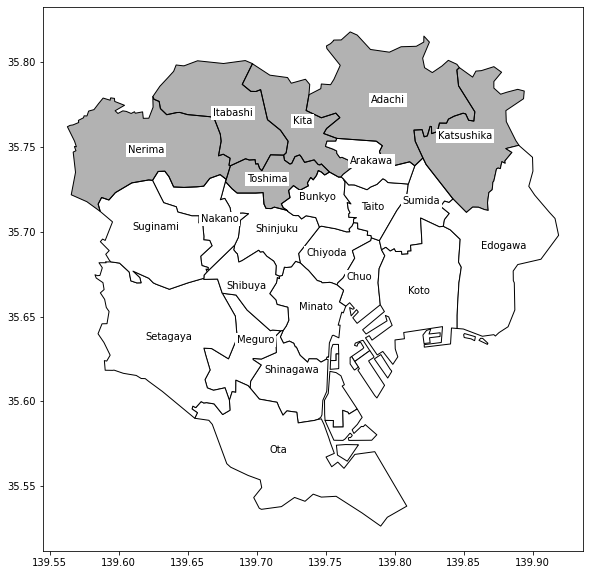

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
api.plot_hotspot(hotspots)
plt.show()

## Bonus: Plotting Detected Hotspots (2)

Discounting by the number of districts.

In [12]:
# hotspots = analyzer.hotspots(result, data=(table43, 'Name', 'n', 'o'), score='binomial')
# hotspots['score'] = hotspots['score'] / hotspots['spot'].map(len)
# hotspots = hotspots.sort_values('score', ascending=False)
# hotspots

In [13]:

# from echelon.contrib.geo import GISPlotter
# GISPlotter(Tokyo_gdf, 'name').plot_hotspot(hotspots, label_col='name', options=dict(nth=1, id_col='SIKUCHOSON'))
# None

## Summary

In [14]:
# import numpy as np
# import pandas as pd
# import geopandas as gpd

# from echelon.api import DataFrameEchelonAnalysis
# from echelon.contrib.geo import GISAdjacency
# from echelon.contrib.geo import GISPlotter

# ## Load data
# table42 = pd.read_csv(data_dir / 'data/table42.csv')
# table43 = pd.read_csv(data_dir / 'data/table43.csv', encoding="shift-jis")

# ## Compute data
# p = table42['o'] / table42['n']
# e = table43['n1']*p[0] + table43['n2']*p[1] + table43['n3']*p[2]
# SMR = table43['o'] / e
# table43['SMR'] = SMR

# ## Attach adjacency information based on shape file
# gdf = gpd.read_file(data_dir / 'shapefile' / 'jpn_adm.shp')
# Tokyo_gdf = gdf[gdf['adm_code'].isin([str(s) for s in range(13101, 13123+1)])].reset_index(drop=True)
# table43['adjacency'] = (GISAdjacency(Tokyo_gdf, id_colname='SIKUCHOSON').to_series()['adjacency'])

# ## Construct Echelon
# analyzer = DataFrameEchelonAnalysis()
# result = analyzer(table43, 'SMR', 'Name', 'adjacency')

# ## Scan hot spots
# hotspots = analyzer.hotspots(result, data=(table43, 'Name', 'n', 'o'), score='binomial')

# ## Plot hot spots
# Tokyo_gdf['name'] = Tokyo_gdf['SIKUCHOSON'].map(lambda s: AlphabetNames[s])
# GISPlotter(Tokyo_gdf, 'name').plot_hotspot(hotspots, label_col='name', options=dict(nth=1, id_col='SIKUCHOSON'))
# None

### Bonus: base plot

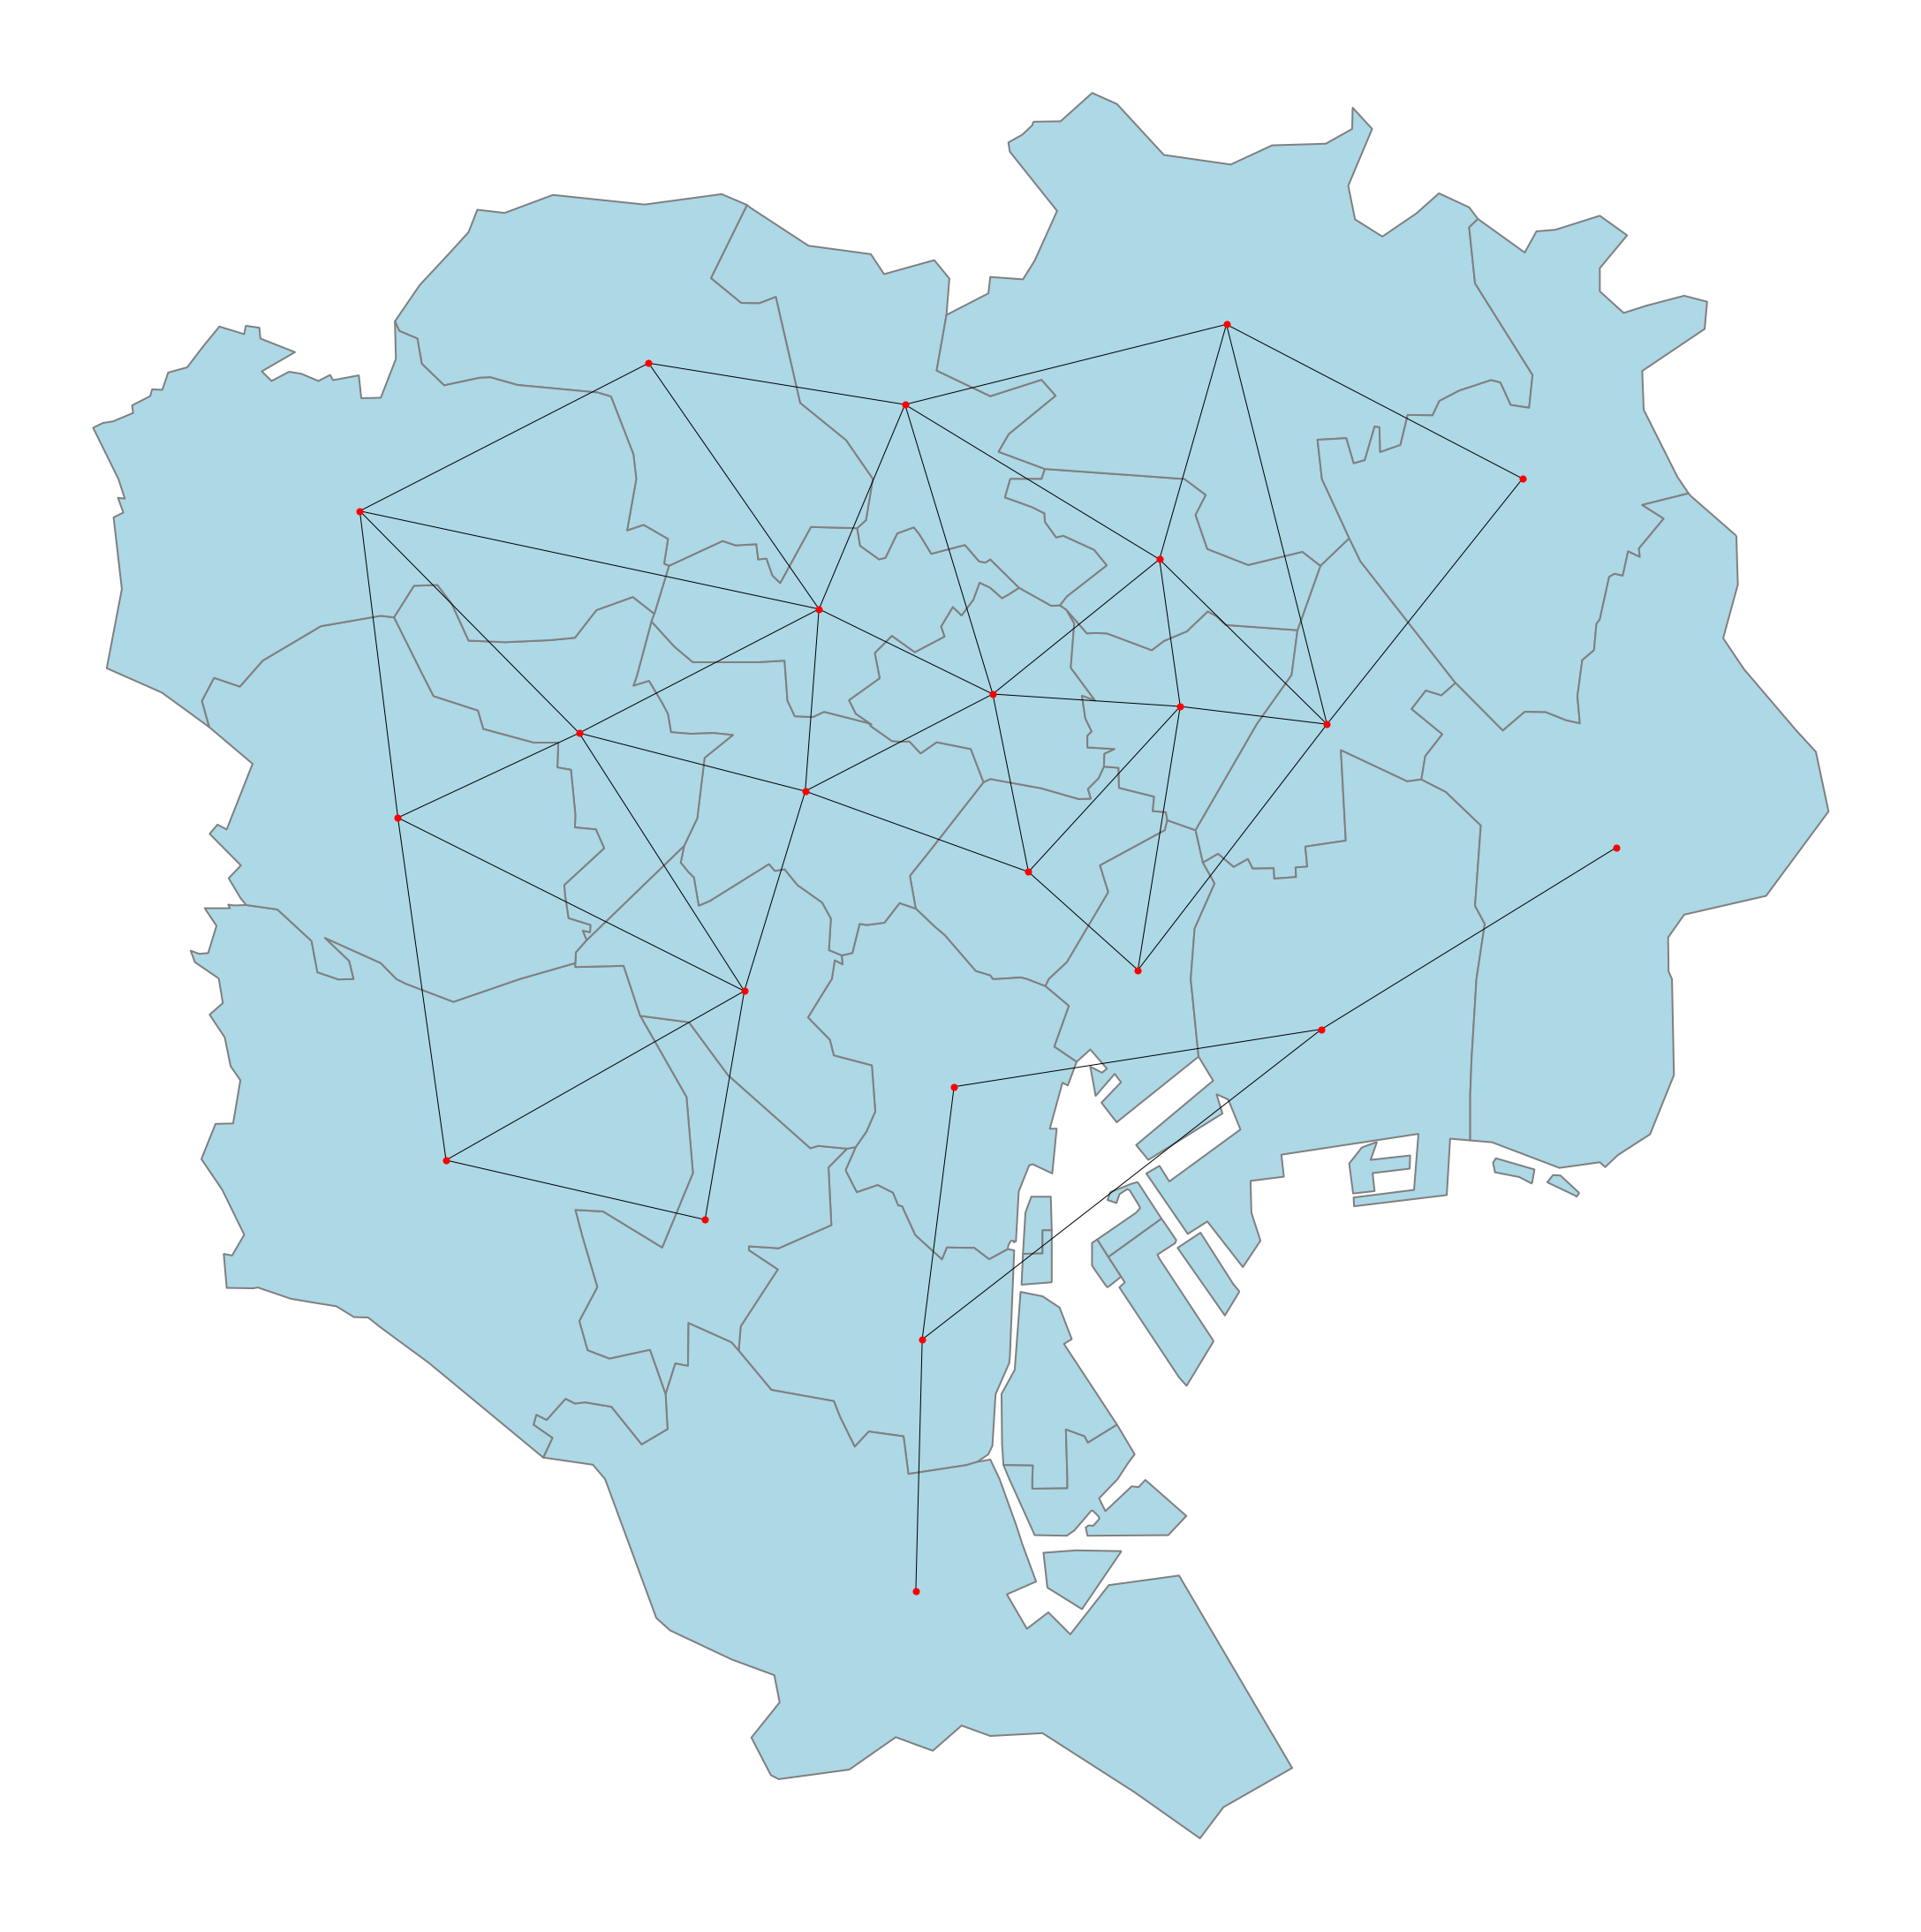

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
api.plot_adjacency()
plt.show()

### Bonus: Data Visualization

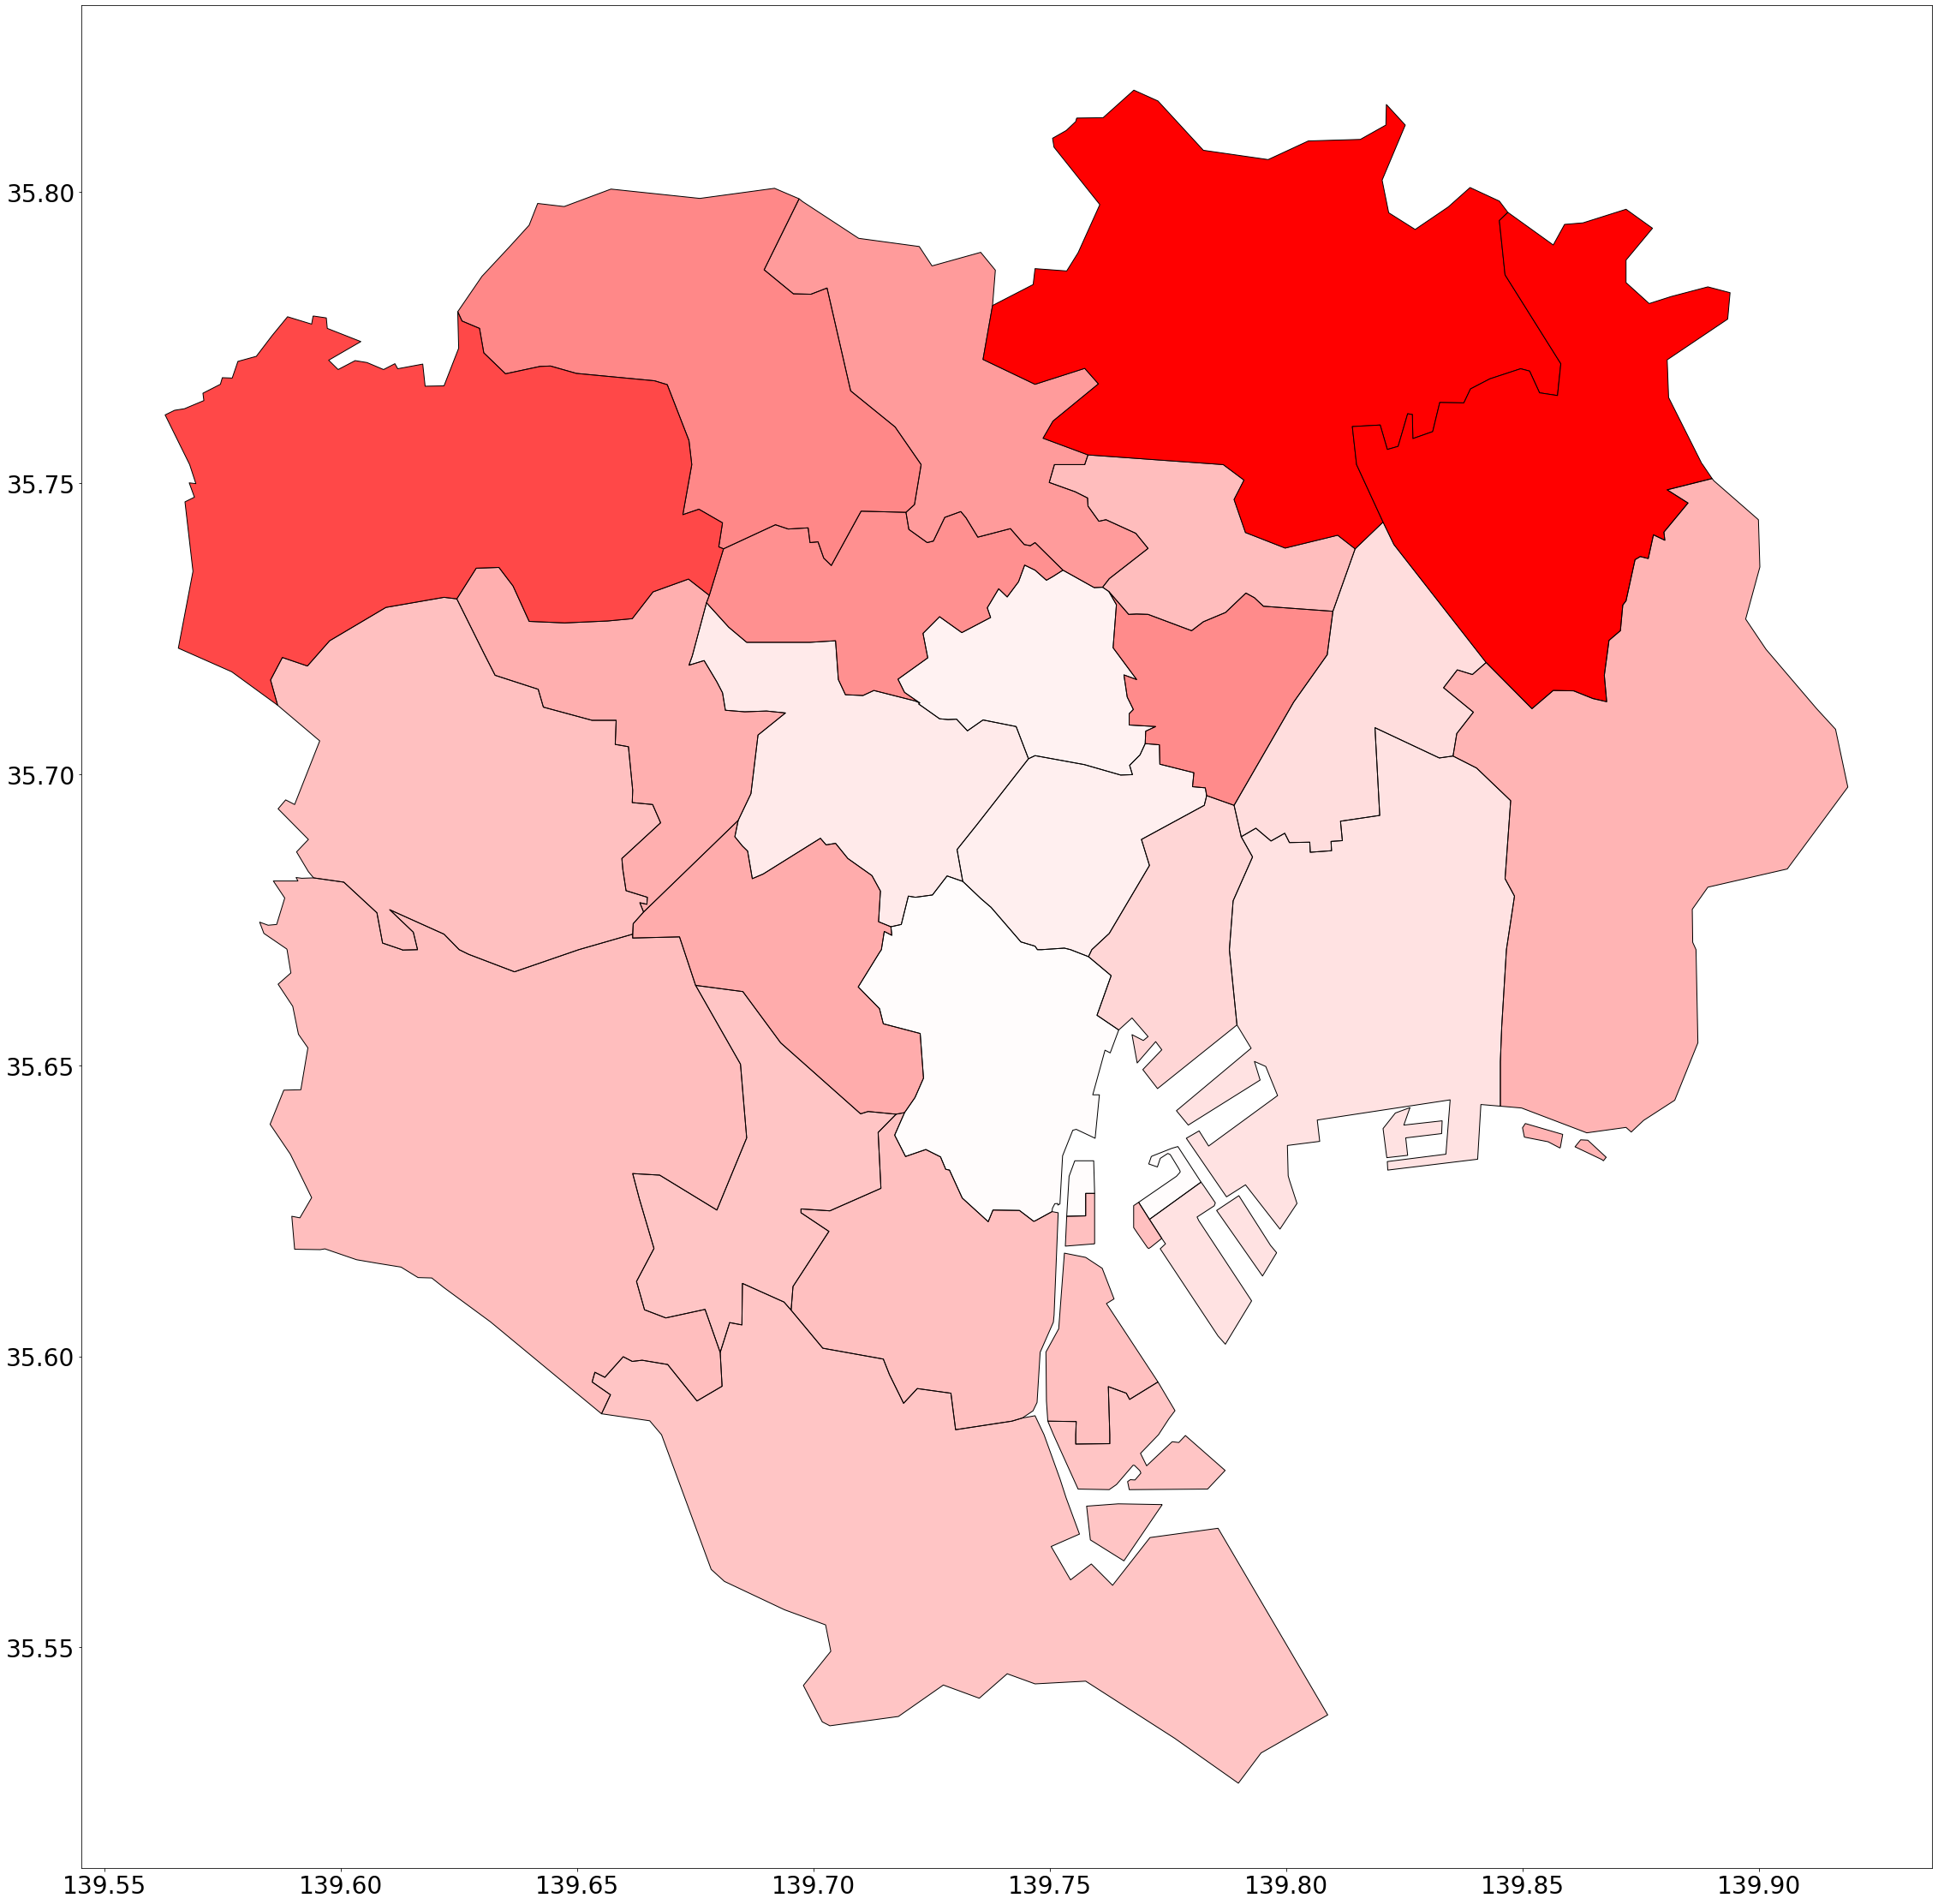

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
api.plot_column('SMR', lambda v: min(1, v * .8) ** 5)
plt.show()